In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [3]:
log2tpm1 = pd.read_csv("../../../data/test/test_input/2023-08-14/synthetic-train-eff-0.5-ndiff-10-frac-0.1-2023-08-14.tsv",
                 sep='\t', index_col=0)

In [4]:
labels = [1 if sample.startswith("responder") else 0 for sample in log2tpm1.columns]

In [5]:
nonresponders = log2tpm1.filter(regex="^nonresponders", axis=1)
responders = log2tpm1.filter(regex="^responders", axis=1)

In [6]:
def calculate_log2_fc(a, b):
    mean_a = np.mean(a, axis=0)
    mean_b = np.mean(b, axis=0)
    return np.log2(mean_a / mean_b)

In [7]:
log2FC = calculate_log2_fc(nonresponders.T, responders.T).sort_values()

In [8]:
# DEG Analysis
stats, pvalues = ttest_ind(nonresponders.T.values, responders.T.values)

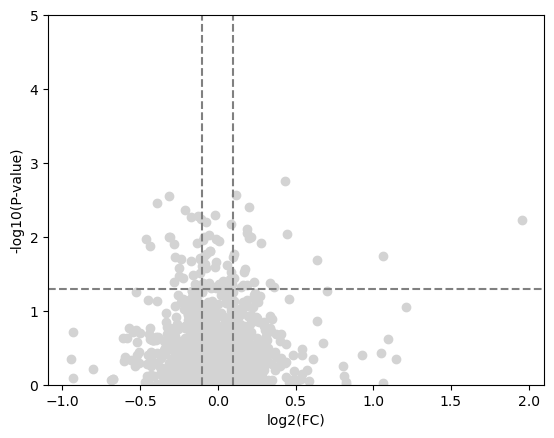

In [9]:
plt.scatter(log2FC, -np.log10(pvalues), color="lightgray")
plt.ylim(0, 5)

plt.xlabel("log2(FC)")
plt.ylabel("-log10(P-value)")

plt.axhline(-np.log10(0.05), linestyle="--", color="gray")
plt.axvline(-0.1, linestyle="--", color="gray")
plt.axvline(0.1, linestyle="--", color="gray")

plt.savefig("../../../figures/synthetic/synthetic-data-volcano-plot.svg", 
            format='svg', 
            bbox_inches='tight')

In [10]:
stats = pd.DataFrame(stats, index=nonresponders.index)

In [11]:
stats

,0
ENSG00000168484,-0.753344
ENSG00000149021,0.239133
ENSG00000096088,-1.295885
ENSG00000198183,-0.517213
ENSG00000122852,-0.189471
...,...
ENSG00000196126,0.048606
ENSG00000134028,1.184489
ENSG00000134443,0.750640
ENSG00000189221,-1.715119


In [12]:
stats.abs().sort_values(0).tail(20).index.values

array(['ENSG00000221867', 'ENSG00000198888', 'ENSG00000282122',
       'ENSG00000244642', 'ENSG00000248527', 'ENSG00000198899',
       'ENSG00000209082', 'ENSG00000225972', 'ENSG00000265735',
       'ENSG00000187867', 'ENSG00000189058', 'ENSG00000211598',
       'ENSG00000211639', 'ENSG00000259884', 'ENSG00000002726',
       'ENSG00000198886', 'ENSG00000021826', 'ENSG00000229807',
       'ENSG00000210077', 'ENSG00000210154'], dtype=object)

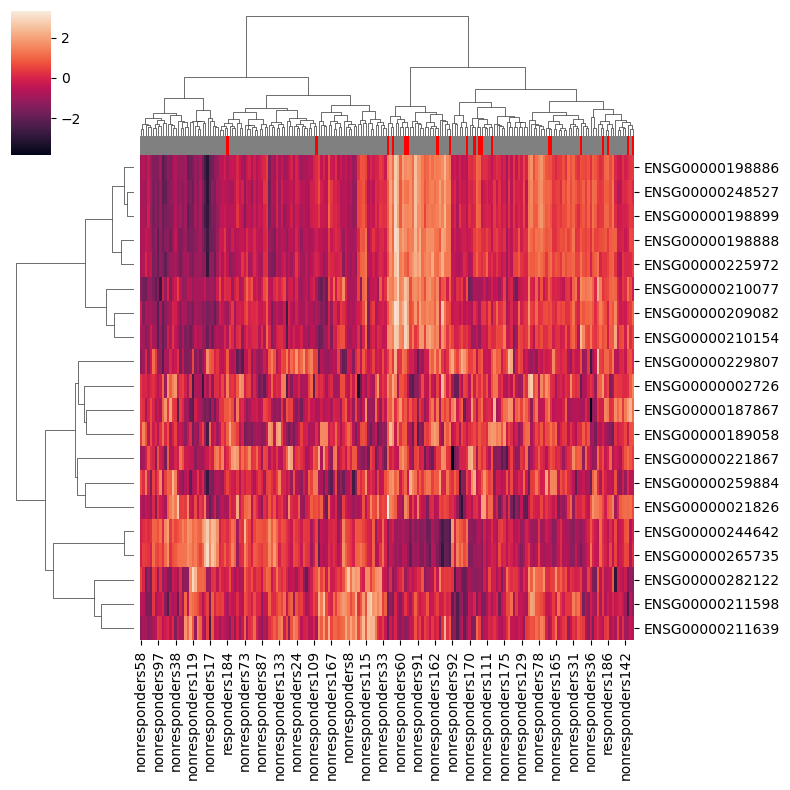

In [16]:
sns.clustermap(log2tpm1.reindex(stats.abs().sort_values(0).tail(20).index), 
               col_colors=["red" if x.startswith("responder") else "gray" for x in log2tpm1.columns], 
               method='ward', z_score=0, figsize=(8, 8))

plt.savefig("../../../figures/synthetic/synthetic-data-ward-hierarchical-cluster-degs.svg", 
            format='svg', 
            bbox_inches='tight')

/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


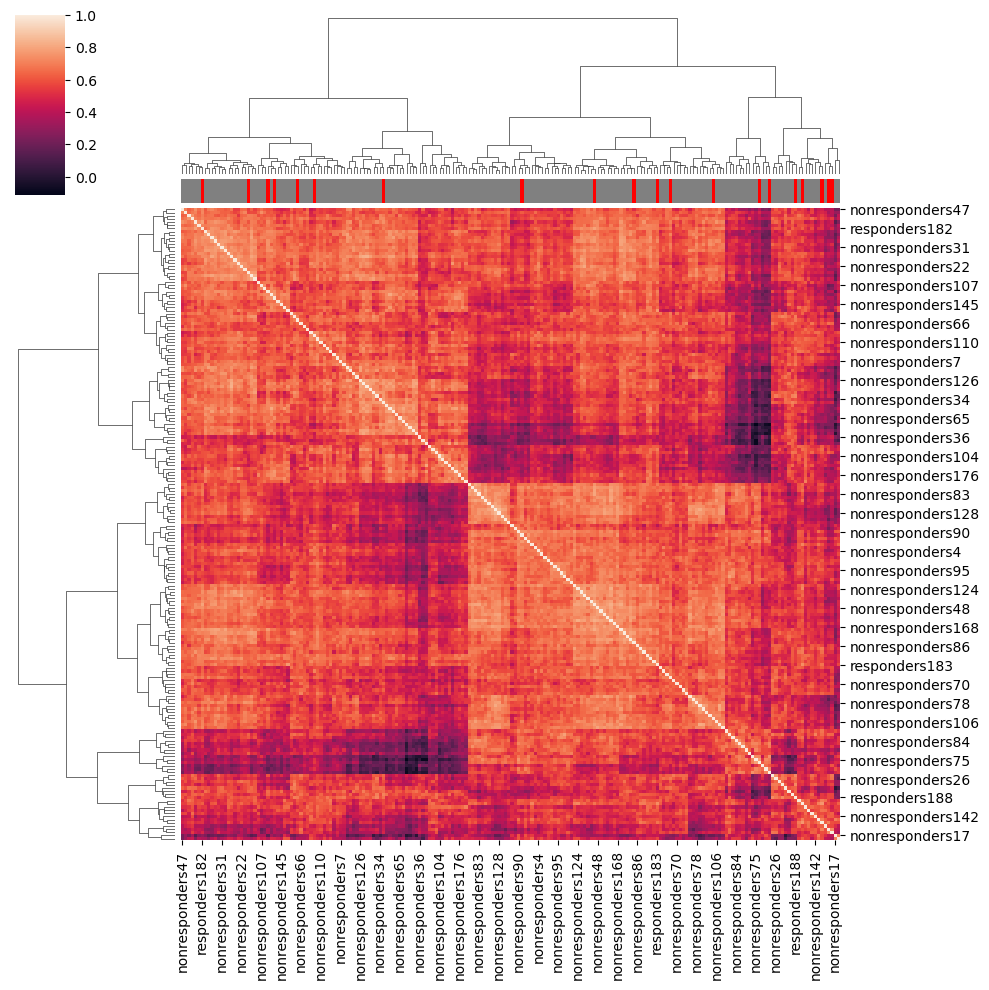

In [13]:
sns.clustermap(log2tpm1.corr(method="spearman"), 
               col_colors=["red" if x.startswith("responder") else "gray" for x in log2tpm1.columns], 
               method='ward')

plt.savefig("../../../figures/synthetic/synthetic-data-ward-hierarchical-cluster-spearmanr.svg", 
            format='svg', 
            bbox_inches='tight')

/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


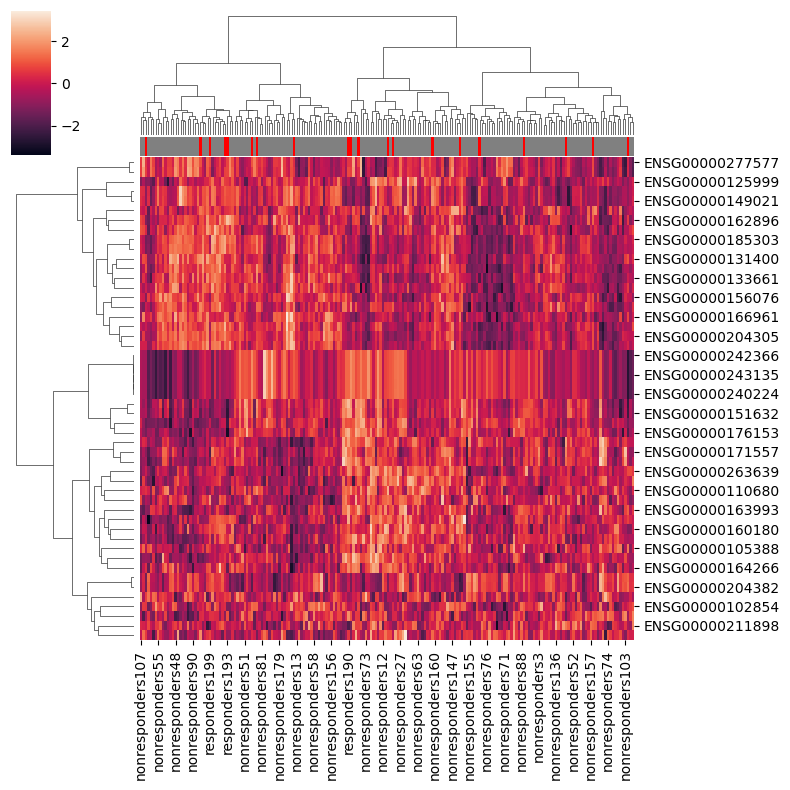

In [17]:
sns.clustermap(log2tpm1.reindex(log2tpm1.var(axis=1).sort_values().tail(50).index.values), 
               col_colors=["red" if x.startswith("responder") else "gray" for x in log2tpm1.columns], 
               method='ward', z_score=0, figsize=(8, 8))

plt.savefig("../../../figures/synthetic/synthetic-data-ward-hierarchical-cluster-top-50-var.svg", 
            format='svg', 
            bbox_inches='tight')

In [18]:
def roll_genes(genes):
    mgenes = np.empty((genes.shape[0], genes.shape[0]), dtype=object)
    for i in range(genes.shape[0]):
        for j, (g1, g2) in enumerate(zip(genes, np.roll(genes, i))):
            mgenes[j, i] = f"{g2}:{g1}"
    return mgenes
    
def divs(array):
    matrix = np.zeros((array.shape[0], array.shape[0]))
    for i in range(array.shape[0]):
        matrix[:, i] = np.roll(array, i)
    return matrix

def col_div(col):
    denominator = col
    numerator = divs(denominator)
    diffs = numerator / denominator[:, np.newaxis]
    return diffs.flatten()

def fast(mat):
    
    mgenes = roll_genes(np.arange(len(mat)))
    
    matrix = pd.DataFrame(index=mgenes.flatten(), 
                          columns=range(mat.shape[1]))
    
    for i in range(mat.shape[1]):
        matrix.loc[:, i] = col_div(mat[i].values)
            
    return matrix

In [19]:
from sklearn import preprocessing

tpm = (2**log2tpm1) - 1.0

scaler = preprocessing.MinMaxScaler(feature_range=(1, 100))
norm = pd.DataFrame(index=tpm.index, columns=log2tpm1.columns)

gene_bounds = pd.DataFrame(index=tpm.index, columns=['q1', 'q2', 'q3', 'upper_outlier', 'lower_outlier'])

for gene in norm.index.values:
    
    try:

        vec = tpm.loc[gene, :].values.reshape(-1, 1)
        q1 = np.percentile(vec, 25)
        q2 = np.percentile(vec, 50)
        q3 = np.percentile(vec, 75)

        upper_outlier = q3 + 1.5 * (q3 - q1)
        lower_outlier = q1 - 1.5 * (q3 - q1)

        gene_bounds.loc[gene, :] = [q1, q2, q3, upper_outlier, lower_outlier]

        idx, _ = np.where(vec > upper_outlier)
        vec[idx] = upper_outlier

        idx, _ = np.where(vec < lower_outlier)
        vec[idx] = lower_outlier

        norm.loc[gene, :] = scaler.fit_transform(vec).flatten()

    except Exception as e:
        print(e)

In [20]:
ratio = fast(pd.DataFrame(norm.values))
ratio = ratio.astype(np.float64)
ratio.columns = tpm.columns

zscore, pval = ttest_ind(ratio.filter(regex="^responders", axis=1).values, ratio.filter(regex="^nonresponders", axis=1).values, axis=1)
zscore = pd.DataFrame(zscore, index=ratio.index).dropna().sort_values(0, ascending=False)
zscore = zscore.sort_values(0)

ratio_hits = list(zscore.tail(10).index.values)

/tmp/ipykernel_31010/3267752930.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  zscore, pval = ttest_ind(ratio.filter(regex="^responders", axis=1).values, ratio.filter(regex="^nonresponders", axis=1).values, axis=1)


In [21]:
ratio

,nonresponders0,nonresponders1,nonresponders2,nonresponders3,nonresponders4,nonresponders5,nonresponders6,nonresponders7,nonresponders8,nonresponders9,...,responders190,responders191,responders192,responders193,responders194,responders195,responders196,responders197,responders198,responders199
0:0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
999:0,4.658137,13.097578,40.838156,0.699800,1.484627,0.627265,4.263306,40.392415,13.079240,3.405014,...,52.106903,4.166234,25.845215,1.000000,0.514589,3.023605,51.524601,0.381576,53.627157,15.631017
998:0,5.694484,10.794048,12.376379,0.130554,0.206497,1.056549,11.153867,8.165398,13.817569,0.624463,...,54.886968,3.658282,14.313636,0.551002,0.760669,0.861805,61.216649,1.000000,27.392507,7.185888
997:0,8.870421,8.482500,24.094625,0.737650,0.606304,0.076786,11.257637,28.034515,65.251153,3.183977,...,6.951130,32.456144,38.264780,0.058713,0.212996,0.699687,8.754776,0.221487,10.355788,11.527845
996:0,1.556195,7.305610,14.475370,3.309339,0.887384,0.068992,49.671595,45.891257,67.993496,6.280029,...,41.974949,10.205104,51.623390,0.112619,0.200525,2.474490,11.830697,0.251225,1.993767,1.409916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4:999,0.385635,0.035776,0.020562,1.749587,0.330172,0.730966,0.347631,0.020639,0.073712,0.532947,...,0.044451,0.147914,0.043423,0.426436,1.151813,0.042338,0.027109,2.620712,0.093313,0.055044
3:999,3.119868,2.841956,0.022958,0.321051,0.016881,1.684374,0.490262,0.038708,6.268817,0.241051,...,1.059104,2.338726,0.458795,0.016848,0.160523,0.217228,0.370118,0.199935,0.179263,0.088569
2:999,0.051600,2.841956,0.022532,0.055980,0.018326,1.684374,0.170125,0.052329,0.085513,0.057961,...,0.148044,0.151379,0.039404,0.104134,3.366251,0.838863,1.318590,2.620712,0.030198,0.072116
1:999,3.119868,0.034746,0.021122,4.770838,0.933527,0.159632,0.320902,0.028736,0.271765,0.678674,...,0.021604,0.149794,3.782807,0.507658,0.305392,0.402743,0.021722,0.046805,0.036677,0.145770


In [22]:
tpm

,nonresponders0,nonresponders1,nonresponders2,nonresponders3,nonresponders4,nonresponders5,nonresponders6,nonresponders7,nonresponders8,nonresponders9,...,responders190,responders191,responders192,responders193,responders194,responders195,responders196,responders197,responders198,responders199
ENSG00000168484,138.537590,39.116938,6.068876,685.393344,947.271322,2218.853696,10.505280,17.895708,4.347578,149.384329,...,6.623256,36.975211,-0.317258,2345.717234,1343.773738,655.123243,10.326597,2345.717234,19.637917,89.960393
ENSG00000149021,1127.529746,1.615699,0.385476,1127.529746,635.394839,95.706323,10.750530,11.378512,37.094522,180.984276,...,4.561368,6.147872,1127.529746,566.333729,91.089041,385.703005,6.457715,8.037152,29.486404,113.164552
ENSG00000096088,4.763962,867.384161,0.687093,0.548974,0.041763,867.384161,-0.331165,23.466144,2.221886,2.960672,...,79.277177,4.618676,-0.606388,81.595882,867.384161,628.206718,867.384161,867.384161,16.744829,38.028499
ENSG00000198183,306.468391,306.468391,-0.331710,16.804751,-0.903125,306.468391,5.508836,4.603106,306.468391,14.612040,...,221.393689,74.466396,33.571965,1.137864,10.715060,54.397817,83.078041,19.598576,51.578046,16.678883
ENSG00000122852,1052.712061,24.791413,8.705655,3303.771864,1769.107981,3926.387872,111.247772,46.497033,17.105894,1141.294467,...,190.384492,56.367769,14.519432,3856.637829,3076.364875,248.120903,98.593519,9167.313133,772.228774,293.140302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000196126,974.300094,361.855299,472.526138,3326.993002,5129.137985,1500.060351,1272.799253,1222.874640,1993.474026,482.277848,...,578.589668,1289.968017,503.101590,2610.799264,1705.213224,2189.614931,118.290858,739.853111,425.192039,3751.014361
ENSG00000134028,1.666704,3.637231,3.433786,21.201562,7.339562,0.743542,15.537160,17.462922,17.623348,9.483473,...,11.502396,5.154575,10.967241,1.789049,1.858466,14.978424,3.148220,4.851504,0.122211,0.805882
ENSG00000134443,6.415577,1.762638,2.778170,1.678198,2.014504,-0.125463,1.016489,5.099181,8.671628,1.832889,...,0.102951,9.240797,3.751608,-0.295316,0.486242,1.431176,0.558018,1.684810,1.339570,5.765999
ENSG00000189221,59.581982,44.065540,24.253329,5.845611,12.786549,152.231129,25.026990,22.170120,25.561892,6.869782,...,109.898149,14.357176,22.192104,83.829584,66.786014,37.536100,137.155583,152.231129,77.704358,52.780454


In [23]:
numerators = [] 
denominators = [] 

for r in ratio_hits:
    n, d = r.split(":")
    if n not in numerators:
        numerators.append(n)
        
    if d not in denominators:
        denominators.append(d)

In [24]:
ratio_hits

['77:899',
 '82:215',
 '303:917',
 '334:917',
 '77:314',
 '113:191',
 '23:314',
 '148:917',
 '35:314',
 '103:248']

In [25]:
ratio.reindex(ratio_hits)

,nonresponders0,nonresponders1,nonresponders2,nonresponders3,nonresponders4,nonresponders5,nonresponders6,nonresponders7,nonresponders8,nonresponders9,...,responders190,responders191,responders192,responders193,responders194,responders195,responders196,responders197,responders198,responders199
77:899,0.663684,0.987003,1.191799,1.079585,0.479200,1.141230,1.000000,0.409599,0.380270,0.817821,...,0.807451,1.120625,0.853318,1.618981,1.061610,1.800710,3.110131,3.930287,1.660636,2.271227
82:215,0.463027,0.642072,1.150012,0.888390,1.163688,0.976355,0.771543,1.179950,1.471158,1.000000,...,0.997976,1.334183,0.389573,15.226369,19.974648,9.209927,1.475278,2.509676,1.157749,1.518313
303:917,0.558702,0.928940,1.000000,1.111405,1.162413,1.058754,1.089996,1.000000,0.915145,1.076095,...,1.125654,1.817190,9.993485,4.527340,2.602498,0.756100,0.143208,0.591065,0.156251,2.449052
334:917,0.591042,0.966950,1.000000,1.145531,1.162413,1.111962,1.097484,1.000000,0.928726,1.103548,...,1.184804,1.783426,10.153953,4.708061,2.623898,0.784590,0.150778,0.630878,0.160551,2.558450
77:314,0.739744,0.685951,1.000000,0.817172,0.905332,1.000000,1.000000,0.590583,0.577524,0.610674,...,5.994447,0.472523,3.533839,1.492473,0.788404,2.315729,5.615071,2.352025,1.532034,1.842954
113:191,1.000000,1.000000,0.584418,0.818201,0.646062,0.773362,0.706147,0.713089,0.798869,0.707971,...,4.181617,7.436001,5.303790,0.559989,0.203264,2.261737,13.654664,1.624138,4.946365,0.616216
23:314,0.862300,0.817198,1.000000,1.237099,0.834523,1.000000,1.000000,0.378421,0.453072,0.647211,...,11.908056,0.220218,3.843719,1.940957,1.769641,1.218298,4.144991,2.274319,0.909437,3.057854
148:917,0.419612,0.965605,1.000000,1.347185,0.953038,1.128138,0.880533,1.000000,1.098963,0.624772,...,5.249617,1.039515,3.169016,3.452017,9.640504,0.905547,0.535649,4.146313,2.589675,3.310386
35:314,0.688368,0.864596,1.000000,1.119702,0.906345,1.000000,1.000000,0.384648,0.590456,0.563805,...,8.304877,0.221295,5.559949,2.023268,3.938502,1.157478,3.690029,2.331480,1.607554,5.919770
103:248,1.087578,1.161933,0.903642,1.382781,0.806880,0.610918,0.516704,1.090260,0.730717,0.854612,...,12.979588,2.773618,1.223200,6.680421,4.656129,1.579824,4.231115,5.528693,1.430934,3.346563


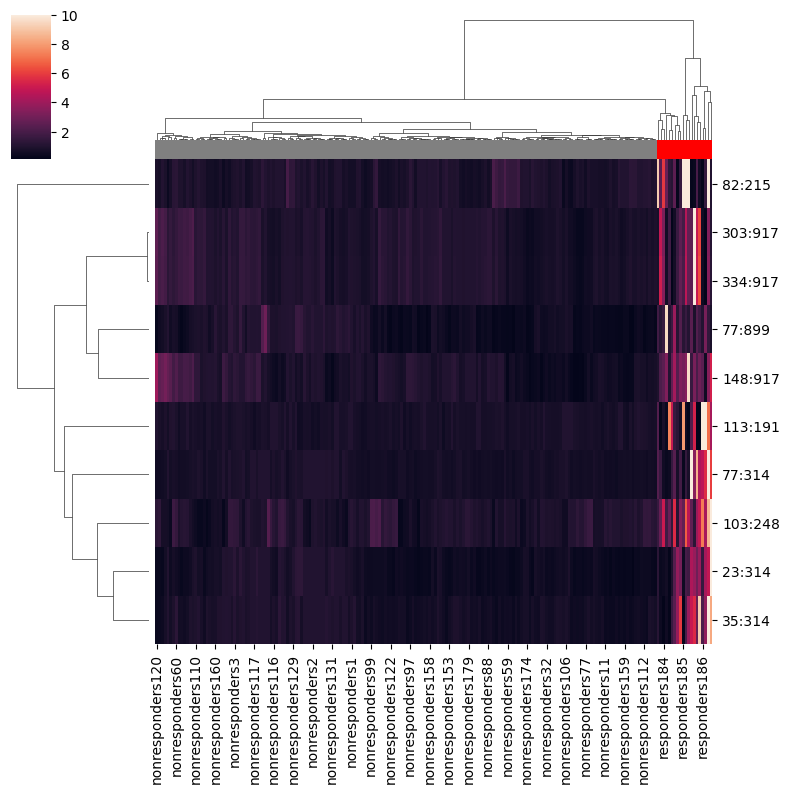

In [27]:
sns.clustermap(ratio.reindex(ratio_hits), 
               col_colors=["red" if x.startswith("responder") else "gray" for x in tpm.columns],
               method="ward",
               vmax=10, figsize=(8, 8))

plt.savefig("../../../figures/synthetic/synthetic-data-ward-hierarchical-cluster-ratios.svg", 
            format='svg', 
            bbox_inches='tight')